In [ ]:
import os
import json
from collections import Counter
from collections import defaultdict
import glob
import re
from tqdm import tqdm

from paddlenlp import Taskflow
from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import umap
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import hstack

d:\Studies\HSE\project\.venv\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
d:\Studies\HSE\project\.venv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# NER

In [2]:
def extract_entity_mentions_with_positions(folder_path, output_folder='ner_texts_mentions'):
    ner = Taskflow("information_extraction", schema=["‰∫∫Âêç"])
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()

        result = ner(text)

        mentions = []
        for entry in result:
            for entity_type, values in entry.items():
                for item in values:
                    mentions.append({
                        "entity": item["text"],
                        "start": item["start"],
                        "end": item["end"],
                        "type": entity_type
                    })

        output_file = os.path.join(output_folder, f"{filename}.json")
        with open(output_file, "w", encoding='utf-8') as outfile:
            json.dump({
                "filename": filename,
                "mentions": mentions
            }, outfile, ensure_ascii=False, indent=2)
        
        print(f"{output_file} created successfully.")

In [3]:
folder_path = r"D:\Studies\HSE\project\texts"
extract_entity_mentions_with_positions(folder_path)

[2025-04-27 16:46:48,486] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.tokenizer.ErnieTokenizer'> to load 'C:\Users\soule\.paddlenlp\taskflow\information_extraction\uie-base'.
d:\Studies\HSE\project\.venv\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:2478: FutureWarning: The `max_seq_len` argument is deprecated and will be removed in a future version, please use `max_length` instead.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\paddlenlp\transformers\tokenizer_utils_base.py:1878: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ner_texts_mentions\‰∏ÄÁ∫ßÂæãÂ∏à[ÊòüÈôÖ].txt.json created successfully.
ner_texts_mentions\‰∏âÁîü‰∏â‰∏ñÂçÅÈáåÊ°ÉËä± by Âîê‰∏ÉÂÖ¨Â≠ê.txt.json created successfully.
ner_texts_mentions\‰∏âÁîü‰∏â‰∏ñÊûï‰∏ä‰π¶‚Äî‚ÄîÂîê‰∏ÉÂÖ¨Â≠ê.txt.json created successfully.
ner_texts_mentions\‰∫åÂìàÂíå‰ªñÁöÑÁôΩÁå´Â∏àÂ∞ä.txt.json created successfully.
ner_texts_mentions\‰∫∫Ê∏£ÂèçÊ¥æËá™ÊïëÁ≥ªÁªü.txt.json created successfully.
ner_texts_mentions\‰ªñÊù•‰∫ÜËØ∑Èó≠Áúº.txt.json created successfully.
ner_texts_mentions\‰Ω†ÊòØÊàëÁöÑÂ∞èÁ°ÆÂπ∏_Âæ°È£é‰πùÂ∞ß.txt.json created successfully.
ner_texts_mentions\ÂÖ®ËÅåÈ´òÊâã_Ëù¥Ëù∂Ëìù.txt.json created successfully.
ner_texts_mentions\Âá∞ÊùÉ_Â§©‰∏ãÂΩíÂÖÉ.txt.json created successfully.
ner_texts_mentions\ÂçÉÁßã.txt.json created successfully.
ner_texts_mentions\ÂêéÂÆ´ÔºöÁîÑÂ¨õ‰º†1.txt.json created successfully.
ner_texts_mentions\Âêõ‰πùÈæÑ.txt.json created successfully.
ner_texts_mentions\Â§©ÂÆòËµêÁ¶è.txt.json created successfully.
ner_texts_mentions\Â´°Â´ÅÂçÉÈáë.txt.json created

# Coreference Resolution (–ø–æ–∫–∞ –±–µ–∑ –º–µ—Å—Ç–æ–∏–º–µ–Ω–∏–π!)

In [ ]:
def build_unique_entity_list(json_folder):
    counter = Counter()

    for filepath in glob.glob(f"{json_folder}/*.json"):
        with open(filepath, encoding='utf-8') as f:
            data = json.load(f)

            for mention in data["mentions"]:
                if mention["type"] == "‰∫∫Âêç":
                    counter[mention["entity"]] += 1

    unique_entities = [{"entity": ent, "count": count} for ent, count in counter.items() if len(ent) < 8]
    return unique_entities

texts_with_ner_mentions = r"D:\Studies\HSE\project\ner_texts_mentions"
# –ø–æ–ª—É—á–∞–µ–º —Å–ø–∏—Å–æ–∫ –∏–º–µ–Ω–æ–≤–∞–Ω–Ω—ã—Ö —Å—É—â–Ω–æ—Å—Ç–µ–π —Å –∫–æ–ª-–≤–æ–º —É–ø–æ–º–∏–Ω–∞–Ω–∏–π
unique_entities_list = build_unique_entity_list(texts_with_ner_mentions)

In [30]:
print(len(unique_entities_list))
unique_entities_list[0]

10549


{'entity': 'ÁáïÁª•‰πã', 'count': 4225}

In [ ]:
def string_similarity(a: str, b: str) -> float:
    return SequenceMatcher(None, a, b).ratio()

def is_valid_entity(entity: str, max_len=10, min_freq=2, bad_keywords=None, min_len=2) -> bool:
    if bad_keywords is None:
        bad_keywords = ["Êàø‰∏ú", "Áî∑‰∫∫", "Â•≥‰∫∫", "Â∞èÂ≠©", "Áà∂‰∫≤", "‰ªÜ‰∫∫", "ËÄÅÂ∏à"]
    if len(entity) < min_len:
        return False
    if len(entity) > max_len and not entity.isascii():
        return False
    for word in bad_keywords:
        if word in entity:
            return False
    return True

def cluster_entities_by_similarity(entity_list, name_sim_threshold=0.9):
    """
    –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è –∏–º–µ–Ω –ø–æ –ø—Ä–∞–≤–∏–ª–∞–º:
      ‚Äì –ü—Ä–µ—Ñ–∏–∫—Å–Ω–æ–µ —Å–æ–≤–ø–∞–¥–µ–Ω–∏–µ –ø—Ä–∏ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–∏ <= 500 —Å–∏–º–≤–æ–ª–æ–≤
      ‚Äì –û–¥–Ω–æ—Å–ª–æ–≥–æ–≤—ã–π –ø–æ—Å—Ç—Ñ–∏–∫—Å –¥–ª—è –¥–≤—É—Å–ª–æ–≥–æ–≤—ã—Ö –∏–º–µ–Ω –ø—Ä–∏ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–∏ <= 500
      ‚Äì –î–≤—É—Å–ª–æ–≥–æ–≤—ã–π –ø–æ—Å—Ç—Ñ–∏–∫—Å
      ‚Äì –û—á–µ–Ω—å –≤—ã—Å–æ–∫–∞—è —Å—Ç—Ä–æ–∫–æ–≤–∞—è –ø–æ—Ö–æ–∂–µ—Å—Ç—å
    """
    # —Å–æ–±–∏—Ä–∞–µ–º –ø–æ–∑–∏—Ü–∏–∏ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π –¥–ª—è –∫–∞–∂–¥–æ–≥–æ alias, –ø–æ—Ç–æ–º—É —á—Ç–æ —Å—É—â–Ω–æ—Å—Ç–∏ –≤ —Å–ø–∏—Å–∫–µ - –Ω–µ —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ!!
    name_to_positions = defaultdict(list)
    for item in entity_list:
        alias = item["alias"]
        start = item["mention_start"]
        if is_valid_entity(alias, min_freq=1, min_len=1):
            name_to_positions[alias].append(start)

    names = list(name_to_positions.keys())

    def min_pos_diff(n1, n2):
        return min(
            abs(p1 - p2)
            for p1 in name_to_positions[n1]
            for p2 in name_to_positions[n2]
        )

    def should_link(n1: str, n2: str) -> bool:
        short, long = (n1, n2) if len(n1) <= len(n2) else (n2, n1)

        pos_diff = min_pos_diff(n1, n2)

        # –ø—Ä–µ—Ñ–∏–∫—Å –ø—Ä–∏ —Ä–∞–∑–Ω–∏—Ü–µ –≤ –ø–æ–∑–∏—Ü–∏—è—Ö <= 500
        if len(short) >= 1 and long.startswith(short) and pos_diff <= 500:
            return True

        # –æ–¥–Ω–æ—Å–ª–æ–≥–æ–≤—ã–π –ø–æ—Å—Ç—Ñ–∏–∫—Å –¥–ª—è –¥–≤—É—Å–ª–æ–≥–æ–≤–æ–≥–æ –∏–º–µ–Ω–∏ –ø—Ä–∏ —Ä–∞–∑–Ω–∏—Ü–µ <= 500
        if len(short) == 1 and len(long) == 2 and long.endswith(short) and pos_diff <= 500:
            return True

        # –¥–≤—É—Å–ª–æ–≥–æ–≤—ã–π –ø–æ—Å—Ç—Ñ–∏–∫—Å
        if len(short) == 2 and long.endswith(short):
            return True

        # –ø–æ—Ö–æ–∂–µ—Å—Ç—å
        if string_similarity(n1, n2) >= name_sim_threshold:
            return True

        return False

    clusters = []
    used = set()

    for name in names:
        if name in used:
            continue

        cluster = []
        queue = [name]
        used.add(name)

        while queue:
            curr = queue.pop(0)
            cluster.append(curr)
            for other in names:
                if other not in used and should_link(curr, other):
                    used.add(other)
                    queue.append(other)

        clusters.append(cluster)

    return clusters
entities_clusters = cluster_entities_by_similarity(test_character_mentions)
# entities_clusters = cluster_entities_by_similarity(unique_entities_list)
# entities_clusters

In [32]:
print(len(entities_clusters))
entities_clusters[100]

6933


['È°æÂä®‰∫ß']

In [33]:
# —Å–º–æ—Ç—Ä–∏–º, —Å–∫–æ–ª—å–∫–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ –≤—Å–µ–≥–æ
print(f"–í—Å–µ–≥–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: {len(entities_clusters)}")

# –∏ —Å–∫–æ–ª—å–∫–æ –∏–∑ –Ω–∏—Ö —Å–æ–¥–µ—Ä–∂–∞—Ç 1 —ç–ª–µ–º–µ–Ω—Ç
singleton_count = sum(1 for cluster in entities_clusters if len(cluster) == 1)
print(f"–û–¥–∏–Ω–æ—á–Ω—ã—Ö –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: {singleton_count} ({singleton_count / len(entities_clusters) * 100:.2f}%)")


–í—Å–µ–≥–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: 6933
–û–¥–∏–Ω–æ—á–Ω—ã—Ö –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: 5579 (80.47%)


In [34]:
def build_alias_dict(entity_list, clusters):
    freq_dict = {e['entity']: e['count'] for e in entity_list}
    alias_dict = {}

    for cluster in clusters:
        # –≤—ã–±–∏—Ä–∞–µ–º —Å–∞–º–æ–µ —á–∞—Å—Ç–æ—Ç–Ω–æ–µ –∏–º—è –∫–∞–∫ "–∫–∞–Ω–æ–Ω"
        canonical = max(cluster, key=lambda name: freq_dict.get(name, 0))
        alias_dict[canonical] = cluster

    return alias_dict

# –ø–æ–ª—É—á–∞–µ–º —Å–ª–æ–≤–∞—Ä—å –≤—Å–µ—Ö –ø–æ—Ö–æ–∂–∏—Ö –∏–º–µ–Ω
entities_names_dict = build_alias_dict(unique_entities_list, entities_clusters)
len(entities_names_dict)

6933

In [35]:
entities_names_dict

{'ÁáïÁª•‰πã': ['ÁáïÁª•‰πã', 'ÁáïÁª•', 'Áª•‰πã'],
 'ÈòÆÈáé': ['ÈòÆÈáé'],
 'Âæ∑Âç°È©¨': ['Âæ∑Âç°È©¨'],
 'ÈáëÂèë': ['ÈáëÂèë'],
 'È°æÊôè': ['È°æÊôè', 'È°æÊôèÂä†', 'È°æÊôèÁúü', 'È°æÊôèË®Ä', 'È°æÊôèÊ≠£'],
 'Ëè≤ÂÖπ': ['Ëè≤ÂÖπ', 'ËâæÁê≥¬∑Ëè≤ÂÖπ', 'È´òÊ†ºÂà©¬∑Ëè≤ÂÖπ', 'ËâæÁê≥', 'ËâæÁê≥Â®ú'],
 'Ëé´Â∞î': ['Ëé´Â∞î'],
 '‰∫®Âà©': ['‰∫®Âà©', '‰∫®Âà©¬∑Â••Âè§ÊñØÈÉΩ', '‰∫®Âà©Â∏å'],
 'ËâæÁª¥ÊñØ': ['ËâæÁª¥ÊñØ', 'ËâæÁª¥'],
 'Ëè≤ËéâËææ': ['Ëè≤ËéâËææ'],
 'Ëø™ÊÅ©': ['Ëø™ÊÅ©'],
 'ÂêâÂ°î': ['ÂêâÂ°î'],
 'ÈòøËíô': ['‰∫öÂΩìÊñØ', '‰∫öÂΩì', 'ÈòøËíô‰∫öÂΩì', 'ÈòøËíô', 'ÈòøËíôÊñ∞'],
 'Ê∏ÖÂáåÂáå': ['Ê∏ÖÂáåÂáå', 'ÂáåÂáå'],
 'Ê¥õÂÖã': ['Ê¥õÂÖã',
  'ÈáëÊØõÊ¥õÂÖã',
  'Â§èÊ¥õÂÖã',
  'Ê¥õÂÖãÂìàÂæ∑',
  'ÈáëÊØõ',
  'Â§èÊ¥õÂÖã¬∑Ëé´Èáå‰∫ö',
  'Â§èÊ¥õÂÖã¬∑Ëé´',
  'Â§èÊ¥õÂÖã¬∑Ëé´Èáå',
  'Â§èÊ¥õÂÖã.Ëé´'],
 'ÈòøÈáåÂÆâÂ®ú': ['ÂÆâÂ®ú', 'ÂÆâÂ®ú¬∑Âç°ÂàóÂ∞ºÂ®ú', 'Â••Âà©ÂÆâÂ®ú', 'ËÉ°ÂÆâÂ®ú', 'ÈòøÈáåÂÆâÂ®ú', 'Â••Âà©ÂÆâ'],
 'ÈúçÂ∏ÉÊñØ': ['ÈúçÂ∏ÉÊñØ'],
 'Á∫¶‰π¶‰∫ö': ['Á∫¶‰π¶‰∫ö', 'Á∫¶‰π¶‰∫ö¬∑ËææÂãí', '‰π¶‰∫ö', 'ËææÂãí', 'ÁΩóÂ∏å¬∑ËææÂãí', '‰∫ö

In [ ]:
# –¥–µ–ª–∏–º –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –¥–ª—è –∫–æ–Ω—Ç–µ–∫—Å—Ç–Ω–æ–≥–æ –æ–∫–Ω–∞
def split_into_sentences(text):
    sentence_enders = re.compile(r'(?<=[„ÄÇÔºÅÔºü!?])')
    sentences = sentence_enders.split(text)
    return [s.strip() for s in sentences if s.strip()]

def invert_alias_dict(alias_dict):
    mention_to_canon = {}
    for canon, aliases in alias_dict.items():
        for alias in aliases:
            mention_to_canon[alias] = canon
    return mention_to_canon

def assign_canonical_mentions_with_sentences(
        mentions_folder, 
        alias_dict, 
        original_texts_folder, 
        output_file='character_mentions_final.jsonl'
        ):
    
    mention_to_canon = invert_alias_dict(alias_dict)
    output = []

    for path in glob.glob(f"{mentions_folder}/*.json"):
        with open(path, encoding='utf-8') as f:
            mention_data = json.load(f)

        filename = mention_data['filename']
        text_path = f"{original_texts_folder}/{filename}"
        with open(text_path, encoding='utf-8') as f:
            full_text = f.read()

        sentences = split_into_sentences(full_text)

        # –∏–Ω–¥–µ–∫—Å –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –ø–æ —Å–∏–º–≤–æ–ª–∞–º
        sentence_boundaries = []
        offset = 0
        for sent in sentences:
            start = full_text.find(sent, offset)
            end = start + len(sent)
            sentence_boundaries.append((start, end))
            offset = end

        for m in mention_data['mentions']:
            name = m['entity']
            if name not in mention_to_canon:
                continue

            canonical = mention_to_canon[name]
            start = m['start']
            end = m['end']

            # –≤ –∫–∞–∫–æ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–∏ –Ω–∞—Ö–æ–¥–∏—Ç—Å—è —É–ø–æ–º–∏–Ω–∞–Ω–∏–µ
            sent_index = None
            for idx, (s_start, s_end) in enumerate(sentence_boundaries):
                if s_start <= start < s_end:
                    sent_index = idx
                    break
            if sent_index is None:
                continue  # –ü—Ä–æ–ø—É—Å—Ç–∏—Ç—å, –µ—Å–ª–∏ –Ω–µ –Ω–∞–π–¥–µ–Ω–æ

            left = max(0, sent_index - 10)
            right = min(len(sentences), sent_index + 11)
            context_sentences = sentences[left:right]
            context = ''.join(context_sentences)

            output.append({
                "canonical": canonical,
                "alias": alias_dict[canonical],
                "filename": filename,
                "mention_start": start,
                "mention_end": end,
                "context": context
            })

    with open(output_file, 'w', encoding='utf-8') as out:
        for entry in output:
            out.write(json.dumps(entry, ensure_ascii=False) + '\n')

    print(f"Context with 21 sentences saved to {output_file}")

In [40]:
assign_canonical_mentions_with_sentences(
        mentions_folder=r'D:\Studies\HSE\project\ner_texts_mentions', 
        alias_dict=entities_names_dict, 
        original_texts_folder=r'D:\Studies\HSE\project\texts', 
)

Context with 21 sentences saved to character_mentions_final.jsonl


# –°–æ–±–∏—Ä–∞–µ–º –∞—Ä—Ö–µ—Ç–∏–ø—ã v2

In [41]:
# —Ä–∞–±–æ—Ç–∞–µ–º —Å —Ñ–∞–π–ª–æ–º character_profiles_1000
with open("character_profiles_top1000.json", encoding="utf-8") as f:
    raw_profiles = json.load(f)

# —Å–æ–±–∏—Ä–∞–µ–º –æ–±—â–∏–π —Å—á–µ—Ç—á–∏–∫ –¥–ª—è –ø—Ä–æ—Å—Ç—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
global_counts = {feat: Counter() for feat in ["verbs","adjs","advs"]}
for prof in raw_profiles.values():
    for feat in global_counts:
        global_counts[feat].update(prof.get(feat, {}))

# –æ—Ç–±–∏—Ä–∞–µ–º —Ç–æ–ø—ã
top_verbs = [w for w, _ in global_counts["verbs"].most_common(500)]
top_adjs = [w for w, _ in global_counts["adjs"].most_common(300)]
top_advs = [w for w, _ in global_counts["advs"].most_common(200)]

# –õ–µ–∫—Å–∏—á–µ—Å–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏

In [ ]:
all_data = []
with open('character_mentions_21sent.jsonl', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line.strip())
        all_data.append(data)

In [131]:
# data['context']
print(len(all_data))
print(all_data[:1])
# print(all_data[0]['context'])

903267
[{'canonical': 'ÁáïÁª•‰πã', 'alias': 'ÁáïÁª•‰πã', 'filename': '‰∏ÄÁ∫ßÂæãÂ∏à[ÊòüÈôÖ].txt', 'mention_start': 342, 'mention_end': 345, 'context': 'ÂçÅ‰∏ÄÊúàÊú´ÔºåÂæ∑Âç°È©¨ÁöÑÂàùÂÜ¨Ôºå‰∏≠Â§ÆÂπøÂú∫‰º†Êù•‰æãË°åÁöÑÊó©ÈíüÔºåÁÅ∞È∏ΩÊãçÁùÄÁøÖËÜÄ‰ªéÂêåÊ†∑ÁÅ∞ÈúæÁöÑÂ§©Á©∫Êé†Ëøá„ÄÇÈò¥Ê≤â„ÄÅÂØíÂÜ∑„ÄÅ‰∏ßÊ∞îÂÜ≤Â§©„ÄÇÂ§öÂ•ΩÁöÑÊó•Â≠êÔºåÈÄÇÂêàÊâìÂÆ∂Âä´ËàçÁªô‰∫∫ÈÄÅÁªàÔºåÂæàË°¨ÁáïÁª•‰πãÊ≠§ÂàªÁöÑÂøÉÊÉÖ„ÄÇÂá†‰∏™ÊúàÂâçÔºå‰ªñËøòÈ°∂ÁùÄ‰∏ÄÁ∫ßÂæãÂ∏àÁöÑÂ§¥Ë°îÔºåÊãÖ‰ªªÁùÄÊòüÈôÖÊ¢ÖÂÖπÂ§ßÂ≠¶Ê≥ïÂ≠¶Èô¢Èô¢Èïø‰∏ÄËÅåÔºåË°£ÂÜ†Ê•öÊ•öÂú∞ÂèÇÂä†ÁùÄÂêçÊµÅËÅöÈõÜÁöÑËä±Âõ≠ÈÖí‰ºöÂë¢‚Ä¶‚Ä¶\nËøôÊâçÂ§ö‰πÖÔºåÂ∞±ÂèòÂæó‰∏ÄË¥´Â¶ÇÊ¥ó‰∫Ü„ÄÇËøô‰ºöÂÑøÊòØÊó©‰∏ä8ÁÇπÔºå‰ªñÊ≠£Ëµ∞Âú®Âæ∑Âç°È©¨Ë•øÈÉ®ÊúÄÊ∑∑‰π±ÁöÑÈªëÂ∏ÇÂå∫Ôºå‰∏ÄËæπÁºìÁºìÂú∞ÂñùÁùÄÂíñÂï°Ôºå‰∏ÄËæπÊâ´ËßÜÁùÄË°óËæπÂïÜÂ∫óÊã•Êå§ÁöÑÊ†áÁâå„ÄÇ‰ªñÁöÑËÑ∏Á¥†ÁôΩÂ•ΩÁúãÔºåÁ•ûÊÉÖÂç¥ÈÄèÁùÄÊµìÈáçÁöÑ‰∏çÁàΩ‰∏éÂ´åÂºÉÔºå‰ªø‰ΩõÂñùÁöÑ‰∏çÊòØÁ≤æÁ£®ÂíñÂï°ÔºåËÄåÊòØÁ∫ØÊ≠£Áå´Â±é„ÄÇ‰ªñÂú®ËøôÈáåËΩ¨‰∫ÜÂçäÂ§©ÔºåÂ∞±ÊòØÊâæ‰∏ÄÂÆ∂ÂêàÈÄÇÁöÑÂ∫ó‚Äî‚ÄîËÉΩÂ∏ÆÂøôÊü•ÁÇπ‰∏úË•øÔºåÊúÄÂ•ΩËøòËÉΩÂäûÂº†ÂÅáËØÅ„ÄÇ‰∫îÂàÜÈíüÂêéÔºåÁáïÁª•

In [5]:
with open(r"D:\Studies\HSE\project\cn_stopwords.txt", "r", encoding="utf8") as doc:
	lines = doc.readlines()

stopwords = set(sw.strip() for sw in lines if sw.strip())
len(stopwords)

897

In [158]:
from ltp import LTP

ltp = LTP()

def extract_features(text):
    result = ltp.pipeline(text, tasks=["cws", "pos"])  # —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏—è + POS
    words = result.cws
    pos_tags = result.pos
    # print(pos_tags)
    
    # –ø–æ–¥—É–º–∞—Ç—å, —á—Ç–æ –¥–µ–ª–∞—Ç—å —Å–æ —Å—Ç–æ–ø-—Å–ª–æ–≤–∞–º–∏, —á—Ç–æ–±—ã –Ω–µ —É–¥–∞–ª–∏—Ç—å –ª–∏—à–Ω–µ–µ...
    verbs = [w for w, t in zip(words, pos_tags) if t.startswith('v') and w.strip() not in stopwords and 1 < len(w.strip()) < 8]
    adjs = [w for w, t in zip(words, pos_tags) if t.startswith('a') and w.strip() not in stopwords and 1 < len(w.strip()) < 8]
    advs = [w for w, t in zip(words, pos_tags) if t == 'd' and w.strip() not in stopwords and 1 < len(w.strip()) < 8]

    return {
        "verbs": verbs,
        "adjs": adjs,
        "advs": advs,
    }

In [152]:
text = all_data[0]['context']
dct = extract_features(text)
print(dct)
# for cat in extract_features(text):
#     print([cat[0]])
print(len('Ëìù'))

{'verbs': ['‰º†Êù•', '‰æãË°å', 'Êé†Ëøá', 'ÂÜ≤Â§©', 'ÈÄÇÂêà', 'ÊãÖ‰ªª', 'ÂèÇÂä†', 'ËÅöÈõÜ', 'Êâ´ËßÜ', 'Â´åÂºÉ', 'Â∏ÆÂøô', 'ÊòæÁ§∫', '‰øÆË°å\n', 'ÂõûÊî∂ÁÆ±', 'ÊÑüÂèó', 'Â°ëÂºè', 'ÂèòÂΩ¢', '‰π†ÊÉØ', 'Êê∫Â∏¶'], 'adjs': ['Èò¥Ê≤â', 'ÂØíÂÜ∑', 'Ê∑∑‰π±', 'Â•ΩÁúã', 'ÊµìÈáç', 'Á≤æÁ£®', 'Á∫ØÊ≠£', 'ÂêàÈÄÇ', 'ÊöñÊ∞î', 'ÊöñÊÑè', 'ÈöèÊÑè'], 'advs': ['ÂêåÊ†∑', '‰∏ÄËæπ', '‰∏ÄËæπ', 'ÊúÄÂ•Ω', 'ÂæàË∂≥']}
1


In [ ]:
def build_profiles_by_aggregated_context(jsonl_path, 
                                         top_n=100, 
                                         output_path="character_profiles_agg.json", 
                                         min_mentions=15):
    character_contexts = defaultdict(list)
    aliases = defaultdict(set)

    # —Å–±–æ—Ä –∫–æ–Ω—Ç–µ–∫—Å—Ç–æ–≤
    with open(jsonl_path, encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            
            data = json.loads(line.strip())
            canonical = data["canonical"]
            aliases[canonical].add(data["alias"])
            character_contexts[canonical].append(data["context"])

    profiles = {}

    for canonical in tqdm(character_contexts, desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π"):
        contexts = character_contexts[canonical]

        if len(contexts) < min_mentions:
            continue

        combined_text = " ".join(contexts)
        feats = extract_features(combined_text)

        profiles[canonical] = {
            "aliases": list(aliases[canonical]),
            "frequency": len(contexts),
            "features": {}
        }

        for cat in feats:
            counter = Counter(feats[cat])
            profiles[canonical]["features"][cat] = [
                word for word, _ in counter.most_common(top_n)
            ]

    with open(output_path, "w", encoding="utf-8") as out:
        json.dump(profiles, out, ensure_ascii=False, indent=2)

    print(f"–°–æ—Ö—Ä–∞–Ω–µ–Ω–æ {len(profiles)} –ø—Ä–æ—Ñ–∏–ª–µ–π –≤ {output_path}")

In [160]:
jsonl_path = r'character_mentions_21sent.jsonl'
build_profiles_by_aggregated_context(jsonl_path)

–û–±—Ä–∞–±–æ—Ç–∫–∞ –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9119/9119 [46:34<00:00,  3.26it/s]   


‚úÖ –°–æ—Ö—Ä–∞–Ω–µ–Ω–æ 2887 –ø—Ä–æ—Ñ–∏–ª–µ–π –≤ character_profiles_agg.json


In [ ]:
def summarize_cluster_behaviors(cluster_csv, profiles_json, top_n=100):

    df = pd.read_csv(cluster_csv)
    with open(profiles_json, encoding='utf-8') as f:
        profiles = json.load(f)

    cluster_members = defaultdict(list)
    for _, row in df.iterrows():
        cluster = row["cluster"]
        character = str(row["character"]).strip()
        cluster_members[cluster].append(character)

    cluster_profiles = {}

    for cluster, members in cluster_members.items():
        verbs = Counter()
        adjs = Counter()
        advs = Counter()

        print(f"\n=== üîé –ö–ª–∞—Å—Ç–µ—Ä {cluster} (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: {len(members)}) ===")

        for character in members:
            if character not in profiles:
                # print(f"–ù–µ –Ω–∞–π–¥–µ–Ω –≤ –ø—Ä–æ—Ñ–∏–ª—è—Ö: {character}")
                continue

            feats = profiles[character].get("features", {})
            empty = True

            for cat_name, counter in [("verbs", verbs), ("adjs", adjs), ("advs", advs)]:
                values = feats.get(cat_name, [])
                if not isinstance(values, list):
                    # print(f"{character} ‚Äî {cat_name} –Ω–µ —Å–ø–∏—Å–æ–∫!")
                    continue

                else:
                    counter.update(values)
                    empty = False
                    # print(f"{character} ‚Äî {cat_name[:4]}: {values[:5]}")

            if empty:
                print(f"‚ö†Ô∏è {character} ‚Äî –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø—É—Å—Ç—ã–µ")

        cluster_profiles[cluster] = {
            "verbs": [w for w, _ in verbs.most_common(top_n)],
            "adjs": [w for w, _ in adjs.most_common(top_n)],
            "advs": [w for w, _ in advs.most_common(top_n)],
            "count": len(members)
        }

        print(f"üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É {cluster}: {len(verbs)} –≥–ª–∞–≥–æ–ª–æ–≤, {len(adjs)} –ø—Ä–∏–ª., {len(advs)} –Ω–∞—Ä–µ—á–∏–π")

    for cluster, data in sorted(cluster_profiles.items()):
        print(f"\nüß† –ö–ª–∞—Å—Ç–µ—Ä {cluster} (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: {data['count']})")
        print(f"  üîπ –ì–ª–∞–≥–æ–ª—ã      : {'„ÄÅ'.join(data['verbs'][:20])}")
        print(f"  üîπ –ü—Ä–∏–ª–∞–≥–∞—Ç–µ–ª—å–Ω—ã–µ: {'„ÄÅ'.join(data['adjs'][:20])}")
        print(f"  üîπ –ù–∞—Ä–µ—á–∏—è      : {'„ÄÅ'.join(data['advs'][:20])}")

## Kmeans

In [162]:
def cluster_characters_kmeans(n_clusters,
                              profile_path="character_profiles_agg.json", 
                              output_csv="character_clusters_kmeans.csv"
                            ):   
    # –ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–æ—Ñ–∏–ª–µ–π
    with open(profile_path, encoding='utf-8') as f:
        profiles = json.load(f)

    characters = []
    verbs_texts = []
    adjs_texts = []
    advs_texts = []

    for name, data in profiles.items():
        characters.append(name)
        verbs_texts.append(" ".join(data["features"].get("verbs", [])))
        adjs_texts.append(" ".join(data["features"].get("adjs", [])))
        advs_texts.append(" ".join(data["features"].get("advs", [])))

    # –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è
    vectorizer_v = TfidfVectorizer()
    vectorizer_a = TfidfVectorizer()
    vectorizer_d = TfidfVectorizer()

    X_verbs = vectorizer_v.fit_transform(verbs_texts)
    X_adjs = vectorizer_a.fit_transform(adjs_texts)
    X_advs = vectorizer_d.fit_transform(advs_texts)

    X = hstack([X_verbs, X_adjs, X_advs])

    # –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)

    # –°–Ω–∏–∂–µ–Ω–∏–µ —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏ –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X.toarray())

    # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    df = pd.DataFrame({
        "character": characters,
        "cluster": labels,
        "x": embedding[:, 0],
        "y": embedding[:, 1]
    })
    df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"‚úÖ –ö–ª–∞—Å—Ç–µ—Ä—ã —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ {output_csv}")

    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df["x"], df["y"], c=df["cluster"], cmap="tab10", s=50)
    plt.title(f"KMeans-–∫–ª–∞—Å—Ç–µ—Ä—ã –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π (k = {n_clusters})")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()

d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


‚úÖ –ö–ª–∞—Å—Ç–µ—Ä—ã —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ character_clusters_kmeans.csv


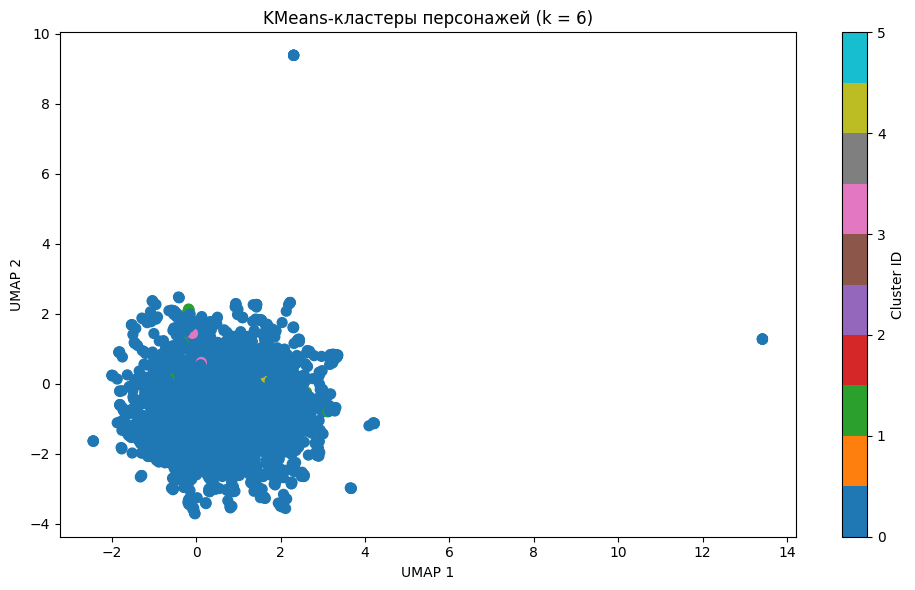

In [170]:
cluster_characters_kmeans(
    profile_path="character_profiles_agg.json",
    output_csv="character_clusters_kmeans.csv",
    n_clusters=6  # –º–æ–∂–Ω–æ –ø—Ä–æ–±–æ–≤–∞—Ç—å 6, 8, 10...
)

In [171]:
summarize_cluster_behaviors(
    cluster_csv="character_clusters_kmeans.csv",
    profiles_json="character_profiles_agg.json",
    top_n=100
)


=== üîé –ö–ª–∞—Å—Ç–µ—Ä 0 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 2872) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 0: 11983 –≥–ª–∞–≥–æ–ª–æ–≤, 5135 –ø—Ä–∏–ª., 2299 –Ω–∞—Ä–µ—á–∏–π

=== üîé –ö–ª–∞—Å—Ç–µ—Ä 2 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 1) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 2: 12 –≥–ª–∞–≥–æ–ª–æ–≤, 5 –ø—Ä–∏–ª., 4 –Ω–∞—Ä–µ—á–∏–π

=== üîé –ö–ª–∞—Å—Ç–µ—Ä 5 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 2) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 5: 54 –≥–ª–∞–≥–æ–ª–æ–≤, 16 –ø—Ä–∏–ª., 9 –Ω–∞—Ä–µ—á–∏–π

=== üîé –ö–ª–∞—Å—Ç–µ—Ä 1 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 9) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 1: 97 –≥–ª–∞–≥–æ–ª–æ–≤, 49 –ø—Ä–∏–ª., 9 –Ω–∞—Ä–µ—á–∏–π

=== üîé –ö–ª–∞—Å—Ç–µ—Ä 3 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 2) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 3: 30 –≥–ª–∞–≥–æ–ª–æ–≤, 13 –ø—Ä–∏–ª., 4 –Ω–∞—Ä–µ—á–∏–π

=== üîé –ö–ª–∞—Å—Ç–µ—Ä 4 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 1) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 4: 17 –≥–ª–∞–≥–æ–ª–æ–≤, 8 –ø—Ä–∏–ª., 4 –Ω–∞—Ä–µ—á–∏–π

üß† –ö–ª–∞—Å—Ç–µ—Ä 0 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 2872)
  üîπ –ì–ª–∞–≥–æ–ª—ã      : ÂèëÁé∞„ÄÅÁ

## HDBSCAN

In [172]:
def cluster_characters_hdbscan(profile_path="character_profiles_agg.json", output_csv="character_clusters_hdbscan.csv", min_cluster_size=5):
    # –ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–æ—Ñ–∏–ª–µ–π
    with open(profile_path, encoding='utf-8') as f:
        profiles = json.load(f)

    characters = []
    verbs_texts = []
    adjs_texts = []
    advs_texts = []

    for name, data in profiles.items():
        characters.append(name)
        verbs_texts.append(" ".join(data["features"].get("verbs", [])))
        adjs_texts.append(" ".join(data["features"].get("adjs", [])))
        advs_texts.append(" ".join(data["features"].get("advs", [])))

    # –û—Ç–¥–µ–ª—å–Ω—ã–µ TF-IDF-–≤–µ–∫—Ç–æ—Ä–∏–∑–∞—Ç–æ—Ä—ã
    v_verb = TfidfVectorizer()
    v_adj = TfidfVectorizer()
    v_adv = TfidfVectorizer()

    X_verbs = v_verb.fit_transform(verbs_texts)
    X_adjs = v_adj.fit_transform(adjs_texts)
    X_advs = v_adv.fit_transform(advs_texts)

    # –û–±—ä–µ–¥–∏–Ω—ë–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    X = hstack([X_verbs, X_adjs, X_advs])

    # –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, prediction_data=True)
    labels = clusterer.fit_predict(X.toarray())

    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è UMAP
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(X.toarray())

    # –¢–∞–±–ª–∏—Ü–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    df = pd.DataFrame({
        "character": characters,
        "cluster": labels,
        "x": embedding[:, 0],
        "y": embedding[:, 1]
    })
    df.to_csv(output_csv, index=False, encoding="utf-8")
    print(f"‚úÖ –ö–ª–∞—Å—Ç–µ—Ä—ã —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ {output_csv}")

    # –û—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df["x"], df["y"], c=df["cluster"], cmap="tab10", s=50)
    plt.title("–ö–ª–∞—Å—Ç–µ—Ä—ã –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π (HDBSCAN + TF-IDF)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(scatter, label="Cluster ID")
    plt.tight_layout()
    plt.show()

d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


‚úÖ –ö–ª–∞—Å—Ç–µ—Ä—ã —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ character_clusters_hdbscan.csv


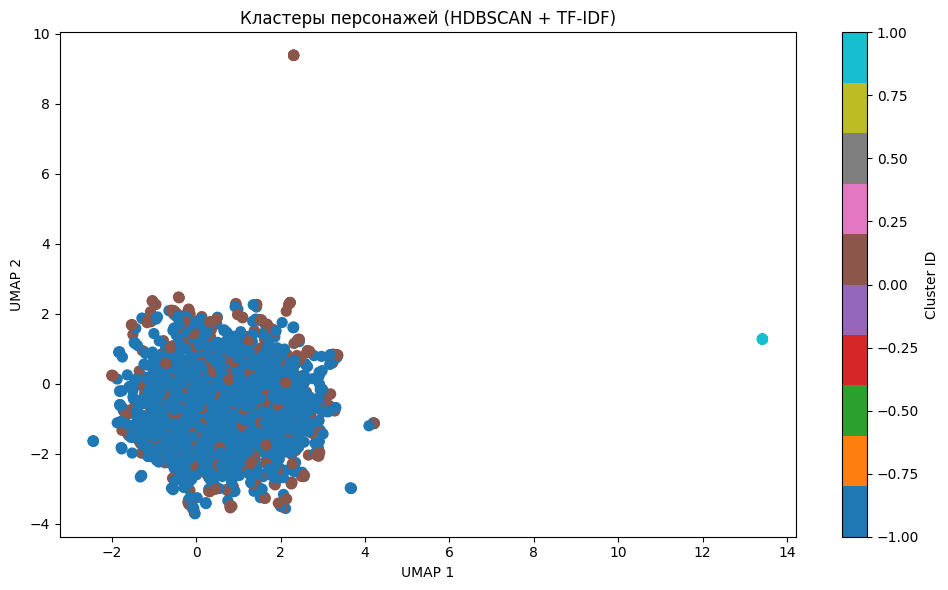

In [173]:
cluster_characters_hdbscan(profile_path=r"character_profiles_agg.json")

In [174]:
hdf = pd.read_csv(r'character_clusters_hdbscan.csv')
hdf

character  cluster         x         y
0          ÁáïÁª•‰πã       -1  0.889475 -1.362479
1           ÈòÆÈáé       -1  0.654609 -0.523655
2          Âæ∑Âç°È©¨       -1  0.500835 -0.461938
3            Èáë        0  0.355246  0.294809
4            Ááï        0  0.388643  0.252899
...        ...      ...       ...       ...
2882       Âº†Êò•ÈæÑ       -1 -0.679066  0.124985
2883        Âç´ÂÖ∞       -1  0.616215 -2.646666
2884        ‰ΩôÊñå       -1 -0.426061 -2.707055
2885        Èí±Á®ã       -1 -0.508036 -2.764824
2886        Âë®Ë∂Ö       -1 -0.549108 -0.473761

[2887 rows x 4 columns]

In [175]:
summarize_cluster_behaviors('character_clusters_hdbscan.csv', 'character_profiles_agg.json')


=== üîé –ö–ª–∞—Å—Ç–µ—Ä -1 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 2332) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É -1: 10947 –≥–ª–∞–≥–æ–ª–æ–≤, 4749 –ø—Ä–∏–ª., 2148 –Ω–∞—Ä–µ—á–∏–π

=== üîé –ö–ª–∞—Å—Ç–µ—Ä 0 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 549) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 0: 3783 –≥–ª–∞–≥–æ–ª–æ–≤, 1374 –ø—Ä–∏–ª., 600 –Ω–∞—Ä–µ—á–∏–π

=== üîé –ö–ª–∞—Å—Ç–µ—Ä 1 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 6) ===
üìå –ò—Ç–æ–≥–æ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä—É 1: 26 –≥–ª–∞–≥–æ–ª–æ–≤, 5 –ø—Ä–∏–ª., 3 –Ω–∞—Ä–µ—á–∏–π

üß† –ö–ª–∞—Å—Ç–µ—Ä -1 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 2332)
  üîπ –ì–ª–∞–≥–æ–ª—ã      : ÂèëÁé∞„ÄÅÁ¶ªÂºÄ„ÄÅÊëáÂ§¥„ÄÅÂñúÊ¨¢„ÄÅÂõûÂ§¥„ÄÅÊãúÊâò„ÄÅ‰º†Êù•„ÄÅÁÇπÂ§¥„ÄÅÊä¨Â§¥„ÄÅÊó†Ê≥ï„ÄÅÁúãÊù•„ÄÅÊ≥®ÊÑè„ÄÅ‰∏ãÂéª„ÄÅÂæÆÁ¨ë„ÄÅÈú≤Âá∫„ÄÅ‰º∏Êâã„ÄÅÊÑüËßâ„ÄÅÂèëÁîü„ÄÅÊâìÁÆó„ÄÅÂèçÂ∫î
  üîπ –ü—Ä–∏–ª–∞–≥–∞—Ç–µ–ª—å–Ω—ã–µ: Ê∏ÖÊ•ö„ÄÅ‰∏çÂ•Ω„ÄÅÁÆÄÂçï„ÄÅÂπ≥Èùô„ÄÅÂÆπÊòì„ÄÅÁ°ÆÂÆû„ÄÅÊ≤âÈªò„ÄÅÈáçË¶Å„ÄÅÂÆâÈùô„ÄÅÊòæÁÑ∂„ÄÅÂ∞èÂøÉ„ÄÅÊòéÁôΩ„ÄÅÈ´òÂÖ¥„ÄÅÊôÆÈÄö„ÄÅÂπ¥ËΩª„ÄÅÊòéÊòæ„ÄÅÂ•áÊÄ™„ÄÅ‰ªîÁªÜ„ÄÅËÆ§Áúü„ÄÅÁ¥ßÂº†
  üîπ –ù–∞—Ä–µ—á–∏—è      : ÂæÆÂæÆ„ÄÅÂ±ÖÁÑ∂„ÄÅÂá†‰πé„Ä

## –ü—ã—Ç–∞–µ–º—Å—è –ø—Ä–æ–∫–ª–∞—Å—Ç–µ—Ä–∏–∑–æ–≤–∞—Ç—å —à—É–º–æ–≤–æ–π –∫–ª–∞—Å—Ç–µ—Ä

In [181]:
df = pd.read_csv("character_clusters_hdbscan.csv")
cluster_minus1 = df[df["cluster"] == -1]
cluster_minus1

character  cluster         x         y
0          ÁáïÁª•‰πã       -1  0.889475 -1.362479
1           ÈòÆÈáé       -1  0.654609 -0.523655
2          Âæ∑Âç°È©¨       -1  0.500835 -0.461938
5           È°æÊôè       -1  0.612043 -0.092275
6            È°æ       -1  0.390341 -0.386575
...        ...      ...       ...       ...
2882       Âº†Êò•ÈæÑ       -1 -0.679066  0.124985
2883        Âç´ÂÖ∞       -1  0.616215 -2.646666
2884        ‰ΩôÊñå       -1 -0.426061 -2.707055
2885        Èí±Á®ã       -1 -0.508036 -2.764824
2886        Âë®Ë∂Ö       -1 -0.549108 -0.473761

[2332 rows x 4 columns]

In [182]:
with open("character_profiles_agg.json", "r", encoding="utf-8") as f:
    profiles = json.load(f)
    
filtered_profiles = {
    char: data for char, data in profiles.items() if char in cluster_minus1["character"].values
}

In [183]:
len(filtered_profiles)

2332

d:\Studies\HSE\project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Studies\HSE\project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


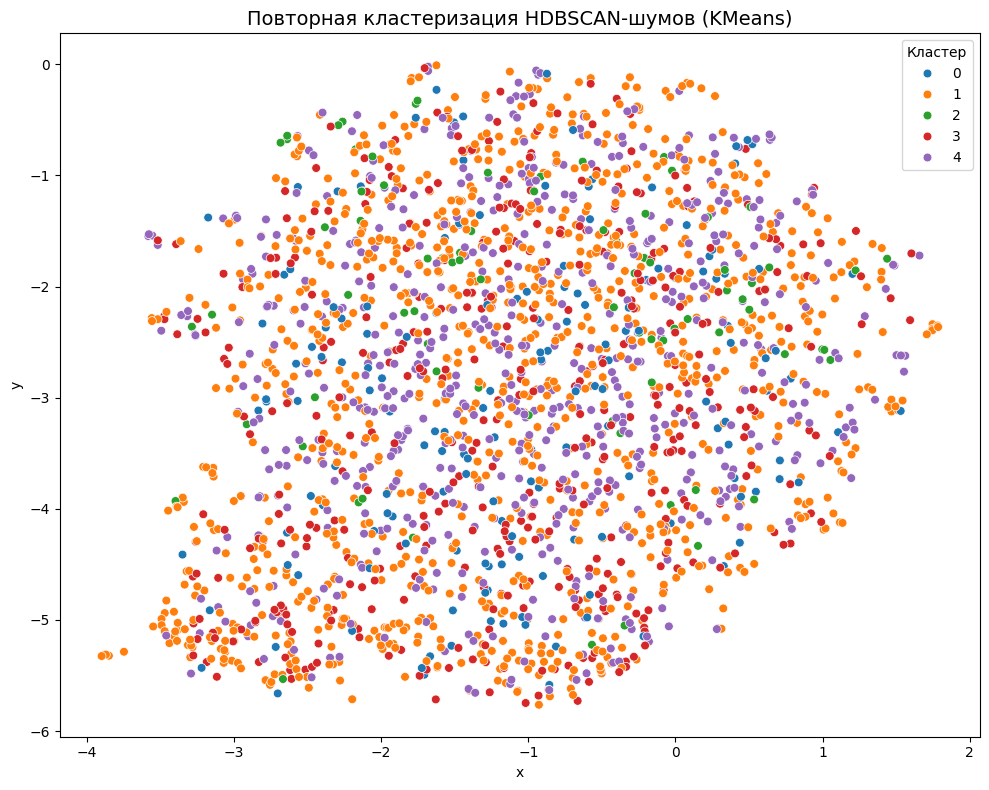

In [188]:
import seaborn as sns
# –°–æ–±–∏—Ä–∞–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏
def profile_to_text(profile):
    feats = []
    for cat in ["verbs", "adjs", "advs"]:
        feats.extend(profile["features"].get(cat, []))
    return " ".join(feats)

texts = [profile_to_text(filtered_profiles[char]) for char in filtered_profiles]
names = list(filtered_profiles.keys())

# –í–µ–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)

# –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è
k = 5  # –º–æ–∂–Ω–æ –≤–∞—Ä—å–∏—Ä–æ–≤–∞—Ç—å
model = KMeans(n_clusters=k, random_state=42)
labels = model.fit_predict(X)

# –†–µ–∑—É–ª—å—Ç–∞—Ç
results = pd.DataFrame({
    "canonical": names,
    "cluster_kmeans": labels
})
# results.to_csv("cluster_minus1_reclustered.csv", index=False, encoding="utf-8-sig")

# UMAP –ø—Ä–æ–µ–∫—Ü–∏—è
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
results["x"] = embedding[:, 0]
results["y"] = embedding[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=results,
    x="x", y="y",
    hue="cluster_kmeans",
    palette="tab10",
    s=40
)
plt.title("–ü–æ–≤—Ç–æ—Ä–Ω–∞—è –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è HDBSCAN-—à—É–º–æ–≤ (KMeans)", fontsize=14)
plt.legend(title="–ö–ª–∞—Å—Ç–µ—Ä")
plt.tight_layout()
plt.show()

In [185]:
results

canonical  cluster_kmeans
0          ÁáïÁª•‰πã               1
1           ÈòÆÈáé               3
2          Âæ∑Âç°È©¨               1
3           È°æÊôè               1
4            È°æ               4
...        ...             ...
2327       Âº†Êò•ÈæÑ               1
2328        Âç´ÂÖ∞               4
2329        ‰ΩôÊñå               1
2330        Èí±Á®ã               4
2331        Âë®Ë∂Ö               1

[2332 rows x 2 columns]

In [190]:
def summarize_cluster_behaviors_again(profiles, cluster_df, label_column="cluster_kmeans", top_n=20):
    cluster_groups = cluster_df.groupby(label_column)

    for cluster_id, group in cluster_groups:
        verbs, adjs, advs = Counter(), Counter(), Counter()
        for canonical in group["canonical"]:
            feats = profiles.get(canonical, {}).get("features", {})
            verbs.update(feats.get("verbs", []))
            adjs.update(feats.get("adjs", []))
            advs.update(feats.get("advs", []))
        
        print(f"\nüß† –ö–ª–∞—Å—Ç–µ—Ä {cluster_id} (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: {len(group)})")
        print("  üîπ –ì–ª–∞–≥–æ–ª—ã      :", "„ÄÅ".join([w for w, _ in verbs.most_common(top_n)]))
        print("  üîπ –ü—Ä–∏–ª–∞–≥–∞—Ç–µ–ª—å–Ω—ã–µ:", "„ÄÅ".join([w for w, _ in adjs.most_common(top_n)]))
        print("  üîπ –ù–∞—Ä–µ—á–∏—è      :", "„ÄÅ".join([w for w, _ in advs.most_common(top_n)]))

summarize_cluster_behaviors_again(filtered_profiles, results)


üß† –ö–ª–∞—Å—Ç–µ—Ä 0 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 162)
  üîπ –ì–ª–∞–≥–æ–ª—ã      : ÂèëÁé∞„ÄÅÁåúÊµã„ÄÅËØÅÊòé„ÄÅÊÑüË∞¢„ÄÅÁúãÊù•„ÄÅÂñúÊ¨¢„ÄÅÁ¶ªÂºÄ„ÄÅÊèêËµ∑„ÄÅ‰º†Êù•„ÄÅÂæÆÁ¨ë„ÄÅÂ≠òÂú®„ÄÅÂõûÂ§¥„ÄÅÊîæÂøÉ„ÄÅÊ±áÊä•„ÄÅ‰º∏Êâã„ÄÅÊî∂Ëóè„ÄÅÈú≤Âá∫„ÄÅÈÅáÂà∞„ÄÅÂõûÂà∞„ÄÅÊãúÊâò
  üîπ –ü—Ä–∏–ª–∞–≥–∞—Ç–µ–ª—å–Ω—ã–µ: ‰∏çË°å„ÄÅÈ∫ªÁÉ¶„ÄÅÂÆπÊòì„ÄÅÊÑâÂø´„ÄÅÊ∏ÖÊ•ö„ÄÅÊòéÁôΩ„ÄÅÂπ≥Èùô„ÄÅÂ•áÊÄ™„ÄÅÂÆâÈùô„ÄÅÂä™Âäõ„ÄÅ‰∏çÂ•Ω„ÄÅÊôÆÈÄö„ÄÅÈ´òÂÖ¥„ÄÅÂ∞èÂøÉ„ÄÅËøÖÈÄü„ÄÅÊºÇ‰∫Æ„ÄÅËÆ§Áúü„ÄÅÊ∏ÖÊô∞„ÄÅÁ°ÆÂÆû„ÄÅÊÉäËÆ∂
  üîπ –ù–∞—Ä–µ—á–∏—è      : Â±ÖÁÑ∂„ÄÅÂæÆÂæÆ„ÄÅ‰∏çË¶Å„ÄÅÂá†‰πé„ÄÅÊ∏êÊ∏ê„ÄÅÊ†πÊú¨„ÄÅ‰πüËÆ∏„ÄÅÊÖ¢ÊÖ¢„ÄÅÊØïÁ´ü„ÄÅ‰∏çË°å„ÄÅÁªùÂØπ„ÄÅÈáçÊñ∞„ÄÅÊú¨Êù•„ÄÅË∂≥‰ª•„ÄÅ‰∏ÄËæπ„ÄÅÂà∞Â∫ï„ÄÅ‰ªéÊù•„ÄÅÊõ¥Âä†„ÄÅÈ°øÊó∂„ÄÅÂΩìÂàù

üß† –ö–ª–∞—Å—Ç–µ—Ä 1 (–ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π: 1053)
  üîπ –ì–ª–∞–≥–æ–ª—ã      : ÂèëÁé∞„ÄÅÊëáÂ§¥„ÄÅÂñúÊ¨¢„ÄÅÊãúÊâò„ÄÅÁÇπÂ§¥„ÄÅ‰º†Êù•„ÄÅÂæÆÁ¨ë„ÄÅÁúãÊù•„ÄÅÊ≥®ÊÑè„ÄÅÊî∂Ëóè„ÄÅÊä¨Â§¥„ÄÅÂèëÁîü„ÄÅÂõûÂ§¥„ÄÅÊó†Ê≥ï„ÄÅÊâìÈáè„ÄÅÈú≤Âá∫„ÄÅÂÆâÊéí„ÄÅÂ∏åÊúõ„ÄÅÁÜüÊÇâ„ÄÅËøõÂÖ•
  üîπ –ü—Ä–∏–ª–∞–≥–∞—Ç–µ–ª—å–Ω—ã–µ: Ê∏ÖÊ•ö„ÄÅ‰∏çÂ•Ω„ÄÅÁÆÄÂçï

# –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∏—Ä—É–µ–º —Å –Ω–æ–≤—ã–º–∏ –ø–∞—Ç—Ç–µ—Ä–Ω–∞–º–∏

In [ ]:
from ltp import LTP

ltp = LTP()

def extract_features_with_dependencies(text, stopwords=stopwords):
    features = {
        "verbs": [],
        "adjs": [],
        "advs": [],
        "adv_verb": [],
        "verb_obj": [],
        "adj_verb": []
    }

    sentences = split_into_sentences(text)

    for sent in sentences:
        pipe = ltp.pipeline([sent], tasks=["cws", "pos", "dep"])
        tokens = pipe.cws[0]
        pos_tags = pipe.pos[0]
        dep_info = pipe.dep[0]  # —Å–ª–æ–≤–∞—Ä—å: {'head': [...], 'label': [...]}

        for word, tag in zip(tokens, pos_tags):
            if word in stopwords or not (1 < len(word) < 8):
                continue
            if tag.startswith("v"):
                features["verbs"].append(word)
            elif tag.startswith("a"):
                features["adjs"].append(word)
            elif tag == "d":
                features["advs"].append(word)

        for dep_idx, (head_idx, rel) in enumerate(zip(dep_info['head'], dep_info['label'])):
            if head_idx == 0:
                continue  # –ø—Ä–æ–ø—É—Å–∫–∞–µ–º —Å–≤—è–∑–∏ —Å root

            head_word = tokens[head_idx - 1]
            dep_word = tokens[dep_idx]
            head_tag = pos_tags[head_idx - 1]
            dep_tag = pos_tags[dep_idx]

            if dep_word in stopwords or head_word in stopwords:
                continue

            if rel == "ADV" and dep_tag == "d" and head_tag.startswith("v"):
                features["adv_verb"].append(f"{dep_word}+{head_word}")

            if rel == "VOB" and head_tag.startswith("v") and dep_tag.startswith("n"):
                features["verb_obj"].append(f"{head_word}+{dep_word}")

            if dep_tag.startswith("a") and head_tag.startswith("v"):
                features["adj_verb"].append(f"{dep_word}+{head_word}")

    for k in features:
        features[k] = Counter(features[k])

    return features

In [213]:
doc = all_data[1]['context']
# print(doc)
extract_features_with_dependencies(doc)

{'verbs': Counter({'Â∏ÆÂøô': 2,
          'ÈÄÇÂêà': 1,
          'ÊâìÂÆ∂Âä´Ëàç': 1,
          'ÈÄÅÁªà': 1,
          'ÊãÖ‰ªª': 1,
          'ÂèÇÂä†': 1,
          'ËÅöÈõÜ': 1,
          'Êâ´ËßÜ': 1,
          'Â´åÂºÉ': 1,
          'ÊòæÁ§∫': 1,
          'ÊÑüÂèó': 1,
          'ÂèòÂΩ¢': 1,
          '‰π†ÊÉØ': 1,
          'Êñπ‰æø': 1,
          'Êê∫Â∏¶': 1,
          'ÈÖçÈÄÇ': 1,
          'ÂèØÊÄú': 1,
          'Âá∫ÂéÇ': 1,
          'ÂêàÊàê': 1}),
 'adjs': Counter({'Ê∑∑‰π±': 1,
          'ÈªëÂ∏ÇÂå∫': 1,
          'Êã•Êå§': 1,
          'Â•ΩÁúã': 1,
          'ÊµìÈáç': 1,
          'Á≤æÁ£®': 1,
          'ÂêàÈÄÇ': 1,
          'Á™ÑÂ∞è': 1,
          'ÈöèÊÑè': 1,
          'Ê∏ÖÂ•á': 1,
          'Âπ≤ÂáÄ': 1}),
 'advs': Counter({'‰∏ÄËæπ': 2, 'Á¥†ÁôΩ': 1, 'ÊúÄÂ•Ω': 1, 'ÊÄªÂÖ±': 1}),
 'adv_verb': Counter({'‰∏ÄËæπ+Âñù': 1, '‰∏ÄËæπ+Êâ´ËßÜ': 1, 'Êõ¥+‰π†ÊÉØ': 1}),
 'verb_obj': Counter({'Ë°¨+ÂøÉÊÉÖ': 1,
          'È°∂+Â§¥Ë°î': 1,
          'ÊãÖ‰ªª+ËÅå': 1,
          'ÂèÇÂä†+ÈÖí‰ºö': 1,
       

In [ ]:
def build_profiles_top_characters_extended(jsonl_path, stopwords, top_n_characters=1000, max_contexts=300, min_mentions=10):
    # –ø–æ–¥—Å—á–µ—Ç —á–∞—Å—Ç–æ—Ç –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π
    char_freq = defaultdict(int)
    character_contexts = defaultdict(list)

    with open(jsonl_path, encoding='utf-8') as f:
        for line in f:
            if not line.strip():
                continue
            data = json.loads(line)
            canonical = data["canonical"]
            character_contexts[canonical].append(data["context"])
            char_freq[canonical] += 1

    top_chars = sorted(char_freq.items(), key=lambda x: x[1], reverse=True)[:top_n_characters]
    top_chars_set = set([c for c, _ in top_chars])

    print(f"–û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º {len(top_chars_set)} —Å–∞–º—ã—Ö —á–∞—Å—Ç–æ—Ç–Ω—ã—Ö –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π...")

    profiles = {}

    for name in tqdm(top_chars_set, desc="–ò–∑–≤–ª–µ—á–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤"):
        contexts = character_contexts[name]
        if len(contexts) < min_mentions:
            continue

        limited_contexts = contexts[:max_contexts]
        combined_text = " ".join(limited_contexts)

        feats = extract_features_with_dependencies(combined_text, stopwords)

        profiles[name] = feats

    with open("character_profiles_top1000.json", "w", encoding="utf-8") as f:
        json.dump(profiles, f, ensure_ascii=False, indent=2)

    print(f"‚úÖ –°–æ—Ö—Ä–∞–Ω–µ–Ω–æ {len(profiles)} –ø–æ–≤–µ–¥–µ–Ω—á–µ—Å–∫–∏—Ö –ø—Ä–æ—Ñ–∏–ª–µ–π –≤ character_profiles_top1000.json")

In [231]:
json_path = r'character_mentions_21sent.jsonl'
build_profiles_top_characters_extended(json_path, stopwords)

üöÄ –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º 1000 —Å–∞–º—ã—Ö —á–∞—Å—Ç–æ—Ç–Ω—ã—Ö –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π...


üîç –ò–∑–≤–ª–µ—á–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1000/1000 [50:08:53<00:00, 180.53s/it]      


‚úÖ –°–æ—Ö—Ä–∞–Ω–µ–Ω–æ 1000 –ø–æ–≤–µ–¥–µ–Ω—á–µ—Å–∫–∏—Ö –ø—Ä–æ—Ñ–∏–ª–µ–π –≤ character_profiles_top1000.json


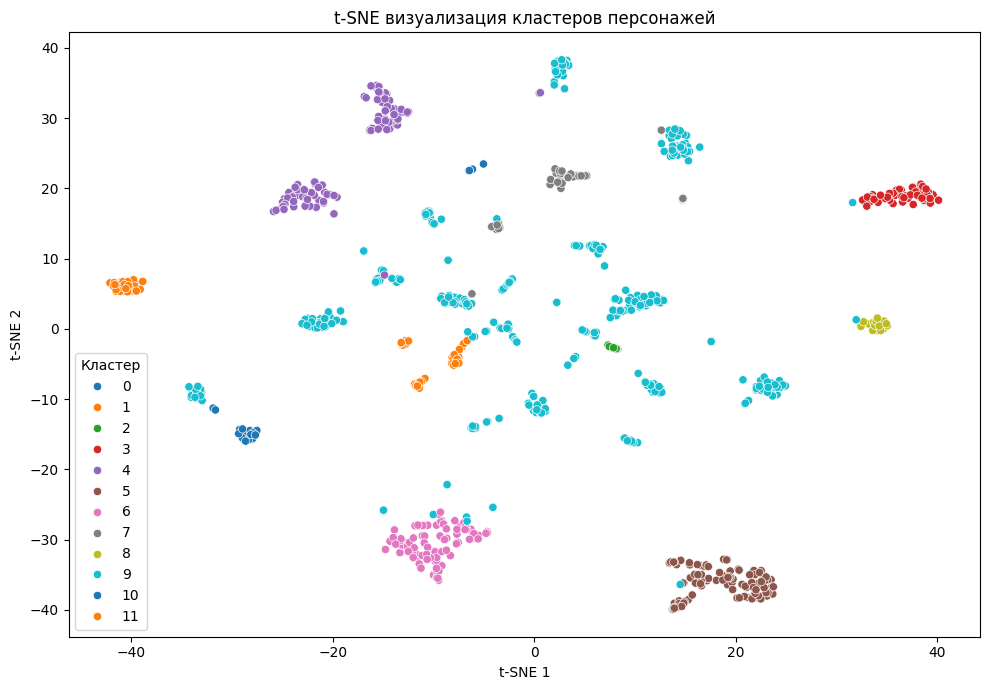

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

with open("character_profiles_top1000.json", encoding="utf-8") as f:
    profiles = json.load(f)

texts = []
names = []
for name, feats in profiles.items():
    tokens = []
    for cat in ['verbs', 'adjs', 'advs', 'verb_obj', 'adv_verb', 'adj_verb']:
        if cat in feats:
            for word, freq in feats[cat].items():
                tokens.extend([word] * freq)
    if tokens:
        texts.append(" ".join(tokens))
        names.append(name)

vectorizer = TfidfVectorizer(max_df=0.65, min_df=10)
X_tfidf = vectorizer.fit_transform(texts)

pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

kmeans = KMeans(n_clusters=12, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_pca)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

df = pd.DataFrame({
    "name": names,
    "cluster": labels,
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1]
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", palette="tab10")
plt.title("t-SNE –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ –ø–µ—Ä—Å–æ–Ω–∞–∂–µ–π")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="–ö–ª–∞—Å—Ç–µ—Ä")
plt.tight_layout()
plt.show()

In [9]:
def summarize_clusters(df, profiles, top_n=10):
    cluster_features = defaultdict(lambda: defaultdict(Counter))

    for _, row in df.iterrows():
        name = row["name"]
        cluster = row["cluster"]
        feats = profiles.get(name, {})
        for cat in ["verbs", "adjs", "advs", "verb_obj", "adv_verb", "adj_verb"]:
            if cat in feats:
                for word, freq in feats[cat].items():
                    cluster_features[cluster][cat][word] += freq

    summaries = {}
    for cluster, cats in cluster_features.items():
        summary = {cat: [w for w, _ in cats[cat].most_common(top_n)] for cat in cats}
        summaries[cluster] = summary

    return summaries

In [10]:
summaries = summarize_clusters(df, profiles, top_n=20)
# summaries

{9: {'verbs': ['ÂèëÁé∞',
   'ÂñúÊ¨¢',
   '‰∏ãÂéª',
   'ÁúãÁúã',
   'Á¶ªÂºÄ',
   'Ë∑üÁùÄ',
   '‰º∏Êâã',
   'ÁÇπÂ§¥',
   'Âøç‰∏ç‰Ωè',
   'ÂèçÂ∫î',
   'ÊÉ≥Ëµ∑',
   'ËøõÂéª',
   'Èú≤Âá∫',
   'ÂºÄÂè£',
   'ÂõûÂ§¥',
   'ÂèëÁîü',
   'Âè™ËÉΩ',
   'ÊòéÁôΩ',
   'ÊÑüËßâ',
   '‰º†Êù•'],
  'adjs': ['‰∏çÂ•Ω',
   'Ê∏ÖÊ•ö',
   'Ê≤âÈªò',
   'Á°ÆÂÆû',
   'ËΩªÊ∑º',
   'È´òÂÖ¥',
   'ÂéâÂÆ≥',
   'Âπ≥Èùô',
   'ÂÆπÊòì',
   'ÈáçË¶Å',
   '‰ªîÁªÜ',
   'ÁÆÄÂçï',
   'ÂÆâÈùô',
   'Â∞èÂøÉ',
   'ÊòæÁÑ∂',
   'ÊòéÁôΩ',
   'Âπ¥ËΩª',
   '‰∏çÂØπ',
   'ÊÉäËÆ∂',
   'Á¥ßÂº†'],
  'advs': ['‰∏ÄËæπ',
   'Â±ÖÁÑ∂',
   '‰∏çË¶Å',
   'ÂæÆÂæÆ',
   'Âà∞Â∫ï',
   'Âá†‰πé',
   'Ê†πÊú¨',
   'ÂÄíÊòØ',
   'ËΩªËΩª',
   'ÊÖ¢ÊÖ¢',
   '‰∏çÁî®',
   'ËøûÂøô',
   'Êú¨Êù•',
   'ÊØïÁ´ü',
   'Â•ΩÂ•Ω',
   '‰ΩéÂ£∞',
   'È°øÊó∂',
   'Ëµ∂Á¥ß',
   'Ê≠£Âú®',
   'ÁºìÁºì'],
  'verb_obj': ['Âèπ+Ê∞î',
   'ÁÇπÁÇπ+Â§¥',
   'ÊëáÊëá+Â§¥',
   'Êä¨+Â§¥',
   'Áö±+Áúâ',
   'ÁùÅ+Áúº',
   '‰Ωé+Â§¥',
   'Êä¨+Êâã',
   'Êùæ+Ê∞î',
   'Êä¨+Áúº',
   'Èóª+‰∫∫ÂéÑ',
   'Êàò+Âåó